In [1]:
import os
import pandas as pd
import numpy as np
import warnings, math, re, pickle, gc, operator, multiprocess, scipy, string, tqdm
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterSampler

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autotime

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from operator import itemgetter
from typing import List, Dict

def on_field(f: str, *vec) -> Pipeline:
    return make_pipeline(FunctionTransformer(itemgetter(f), validate=False), *vec)

In [3]:
train = pd.read_csv('/home/bananamachine/.kaggle/competitions/movie-genres-by-dialogue/train.csv.zip')
test = pd.read_csv('/home/bananamachine/.kaggle/competitions/movie-genres-by-dialogue/X_test.csv.zip')
sample_submission = pd.read_csv('/home/bananamachine/.kaggle/competitions/movie-genres-by-dialogue/sample_submission_most_popular.csv')

def clean_labels(text):
    text = re.sub('-', '', text)
    return text 

train.genres = train.genres.map(lambda x: clean_labels(x))
label_vectorizer = CountVectorizer()
train_y = label_vectorizer.fit_transform(train.genres).todense()
label_cols = label_vectorizer.get_feature_names()

time: 636 ms


>### Add features

In [35]:
from nltk import pos_tag, word_tokenize

def pos_tags(data):
    if __name__ == "__main__": 
        with multiprocess.Pool() as p:
            result = list(tqdm.tqdm_notebook(p.imap(lambda x: " ".join([toople[1] if toople else '' for toople in pos_tag(word_tokenize(x))]), 
                                                    iter(data), chunksize=100), total=len(data)))
        return result

train['dialogue_pos'] = pos_tags(train['dialogue'])
test['dialogue_pos'] = pos_tags(test['dialogue'])


time: 16.3 s


In [11]:
vectorizer = make_union(
    on_field('dialogue_pos', TfidfVectorizer(sublinear_tf=True, token_pattern='\w+')),
)

pos_features = \
    TfidfVectorizer(sublinear_tf=True, token_pattern='\w+')\
        .fit(train['dialogue_pos'])\
        .get_feature_names()
    
train = pd.concat([train, pd.DataFrame(data=vectorizer.fit_transform(train).todense(), columns=pos_features)], 1)
test = pd.concat([test, pd.DataFrame(data=vectorizer.transform(test).todense(), columns=pos_features)], 1)

time: 2.54 s


In [12]:
for data in [train, test]:
    data['dialogue'] = data['dialogue'].apply(lambda x:str(x))
    data['total_length'] = data['dialogue'].apply(len)
    data['capitals'] = data['dialogue'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    data['caps_vs_length'] = data.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
    data['num_words'] = data.dialogue.str.count('\S+')
    data['num_unique_words'] = data['dialogue'].apply(lambda comment: len(set(w for w in comment.split())))
    data['words_vs_unique'] = data['num_unique_words'] / data['num_words'] 
    data['count_sent'] = data["dialogue"].apply(lambda x: len(re.findall("<BR>",str(x)))+1)
    data['count_word'] = data["dialogue"].apply(lambda x: len(str(x).split()))
    data['count_unique_word'] = data["dialogue"].apply(lambda x: len(set(str(x).split())))
    data['count_letters'] = data["dialogue"].apply(lambda x: len(str(x)))
    data["count_punctuations"] = data["dialogue"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    data["count_words_upper"] = data["dialogue"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    data["count_words_title"] = data["dialogue"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    data["count_stopwords"] = data["dialogue"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
    data["mean_word_len"] = data["dialogue"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    data['word_unique_percent'] = data['count_unique_word']*100/data['count_word']
    data['punct_percent'] = data['count_punctuations']*100/data['count_word']

time: 7.55 s


In [14]:
columns = [
    'total_length', 'capitals', 'caps_vs_length', 'num_words', 
    'num_unique_words', 'words_vs_unique', 'count_letters', 
    'count_punctuations', 'count_words_upper', 'count_words_title', 
    'count_stopwords', 'mean_word_len', 'word_unique_percent', 'punct_percent'
]

def get_mean_cols(df, col_name, op, groupby_col):
    if col_name==groupby_col:
        return df
    if op=='mean':
        return pd.merge(df, df.groupby(groupby_col)[[col_name]].mean().reset_index().rename(columns={col_name:'{}_mean'.format(col_name)}), on=groupby_col )    
    if op=='median':
        return pd.merge(df, df.groupby(groupby_col)[[col_name]].median().reset_index().rename(columns={col_name:'{}_median'.format(col_name)}), on=groupby_col )    
    if op == 'sum':
        return pd.merge(df, df.groupby(groupby_col)[[col_name]].sum().reset_index().rename(columns={col_name:'{}_sum'.format(col_name)}), on=groupby_col )    
    if op=='q25':
        return pd.merge(df, df.groupby(groupby_col)[[col_name]].apply(lambda x:np.percentile(x, 25)).reset_index(), how='left', on=groupby_col).rename(columns={0:'{}_q25'.format(col_name)})    
    if op=='q80':
        return pd.merge(df, df.groupby(groupby_col)[[col_name]].apply(lambda x:np.percentile(x, 80)).reset_index(), how='left', on=groupby_col).rename(columns={0:'{}_q80'.format(col_name)}) 
    if op=='q75':
        return pd.merge(df, df.groupby(groupby_col)[[col_name]].apply(lambda x:np.percentile(x, 75)).reset_index(), how='left', on=groupby_col).rename(columns={0:'{}_q75'.format(col_name)}) 
    return df

for f in ['mean', 'sum', 'q25', 'q75', 'q80']:
    for col_name in columns:
        train = get_mean_cols(train, col_name, f, 'count_sent')
        test = get_mean_cols(test, col_name, f, 'count_sent')

time: 9.6 s


>### Load sentiment

In [16]:
train_sent = pd.read_csv('predictions/sent_prob.csv', usecols = ['neg'])
test_sent = pd.read_csv('predictions/sent_prob_test.csv', usecols = ['neg'])

train = pd.concat([train, train_sent], 1)
test = pd.concat([test, test_sent], 1)

time: 72.8 ms


>### Load stacked

In [17]:
predictions = [
    'lr0',
    'nb0',
    'lr1',
    'nb1',
    
    'lrchar0',
    'nbchar0',
    'lrchar1',
    'nbchar1',

    'lrword0',
    'nbword0',
    'lrword1',
    'nbword1',

    'lrword0ngram12',
    'nbword0ngram12',
    'lrword1ngram12',
    'nbword1ngram12',
    
    'lrlemm0',
    'nblemm0',
    'lrlemm1',
    'nblemm1',

    'mlp0',
    'mlp0ngram12',
    
    'rnnft0',
    'rnnbpe0',
    'rnnglove0',
    
    'ft0',
    'ft050',  
]

for pred in predictions:
    p_train = pd.read_csv('predictions/pred_train_{}.csv'.format(pred))
    p_test = pd.read_csv('predictions/pred_test_{}.csv'.format(pred))
    train = pd.concat([train, p_train], 1)
    test = pd.concat([test, p_test], 1)

time: 16 s


>### Fit

In [28]:
train_X = train.iloc[:, 5:]
test_X = test.iloc[:, 3:]

print(train_X.shape, test_X.shape)

(36991, 662) (9403, 662)
time: 1.43 ms


In [23]:
def val_predict_fold_lgbm(j, params, dev_index, val_index):
    pred_train_y = np.zeros(len(train_X))
    dev_X, val_X = train_X.iloc[dev_index], train_X.iloc[val_index]
    dev_y, val_y = np.squeeze(np.array(train_y[:, j][dev_index])), np.squeeze(np.array(train_y[:, j][val_index]))
    _train = lgbm.Dataset(dev_X, dev_y)
    _val = lgbm.Dataset(val_X, val_y)        
    model = lgbm.train(params, _train, num_boost_round=9000, valid_sets=_val, early_stopping_rounds=20, verbose_eval=0) 
    score = model.best_score['valid_0'][params['metric']]
    pred_train_y[val_index] = model.predict(val_X)
    pred_test_y = model.predict(test_X)   
    del model, dev_X, val_X, dev_y, val_y, _train, _val; gc.collect();
    return score, pred_train_y, pred_test_y

def val_predict_oof_lgbm(i, n, params):  
    if __name__ == '__main__':
        kf = StratifiedKFold(n_splits=n, shuffle=True, random_state=0)
        with multiprocess.Pool(n) as p:
            r = list(p.imap(lambda x: val_predict_fold_lgbm(i, params, x[0], x[1]), kf.split(train_y[:, i], train_y[:, i]), chunksize=1))
    return r, np.mean([x[0] for x in r]), np.sum([x[1] for x in r], axis=0), np.sum([x[2] for x in r], axis=0) / float(n)

time: 14.3 ms


In [27]:
params = {
    'colsample_bytree': 0.2,
    'subsample': 0.6,
    'num_leaves': 9,
    'min_gain_to_split': 0.01,
    'min_child_samples': 30,
    'learning_rate': 0.01,
    'reg_alpha': 0.001,
    'reg_lambda': 0.001, 
    'max_bin': 300,    
    
    'objective': 'binary',
    'metric': 'auc',
    'subsample_freq': 1,
    'max_depth': -1,
    'random_state': 1234567890,
    'n_jobs': 1,    
}

preds_test = np.zeros((test_X.shape[0], len(label_cols)))
preds_train = np.zeros((train_X.shape[0], len(label_cols)))
cv_scores = list()

for i, j in enumerate(label_cols):
    print('cv', j)
    r, scores, pred_train, pred_test = val_predict_oof_lgbm(i, 5, params)
    preds_train[:, i] = pred_train
    preds_test[:, i] = pred_test.flatten()
    cv_scores.append(np.mean(scores))
    print(np.mean(scores))
    
print(np.mean(cv_scores))

cv action
0.9213831843292276
cv adventure
0.9203341085049626
cv animation
0.7303369099768667
cv biography
0.888443052056014
cv comedy
0.9272339519520404
cv crime
0.8972583404073624
cv drama
0.9190782907015886
cv family
0.8989620700573855
cv fantasy
0.8614702362478251
cv history
0.8609490756481752
cv horror
0.8671987007410671
cv music
0.8859602699104332
cv musical
0.9006018246869181
cv mystery
0.8563225757258168
cv romance
0.8803340080472009
cv scifi
0.9420167833116428
cv sport
0.9249705805641639
cv thriller
0.9186861396442649
cv war
0.9321228794564306
cv western
0.8852123007277857
0.8909437641348585
time: 2min 47s


>### Thresholds

In [29]:
from sklearn.metrics import f1_score

def f1_metric(y_true_in, y_pred_in):
    metric = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for dev_index, val_index in kf.split(y_true_in, y_true_in):
        f1 = f1_score(y_true_in[val_index], y_pred_in[val_index])
        metric.append(f1)
    return np.mean(metric)

time: 6.24 ms


cv action
0.6609032325918152 [0.36469388]
cv adventure
0.5163246962355662 [0.15510204]
cv animation
0.04379823075475249 [0.01]
cv biography
0.3577401127096852 [0.12285714]
cv comedy
0.7156625509311713 [0.38081633]
cv crime
0.5937507215572783 [0.28408163]
cv drama
0.8410599701566962 [0.39693878]
cv family
0.21537644544997486 [0.0422449]
cv fantasy
0.36311511464853063 [0.10673469]
cv history
0.14386855404461946 [0.01]
cv horror
0.366652279870308 [0.12285714]
cv music
0.24143114543114544 [0.05836735]
cv musical
0.25079771038850324 [0.01]
cv mystery
0.42128694770659025 [0.21959184]
cv romance
0.5520826618289357 [0.26795918]
cv scifi
0.644487021938517 [0.25183673]
cv sport
0.40142520418973165 [0.0422449]
cv thriller
0.7793917706248387 [0.39693878]
cv war
0.39846964704508353 [0.0744898]
cv western
0.23850250698046604 [0.02612245]


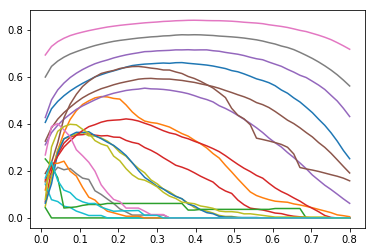

time: 16.3 s


In [30]:
thresholds = np.linspace(0.01, 0.8, 50)
optimal_thresholds = []

for i, j in enumerate(label_cols):
    f1s = []
    print('cv', j)
    for t in thresholds:
        f1s.append(f1_metric(np.squeeze(np.array(train_y[:, i])), preds_train[:, i] > t))
    _=plt.plot(thresholds, f1s)
    optimal_thresholds.append(thresholds[f1s == np.max(f1s)][0])
    print(np.max(f1s), thresholds[f1s == np.max(f1s)])

In [29]:
preds_test_new = np.zeros(preds_test.shape)
for i in range(20):
    preds_test_new[:, i] = preds_test[:, i] > optimal_thresholds[i]

time: 3.34 ms


In [30]:
sample_submission['genres'] = \
    [' '.join(np.array(label_cols)[np.where(preds_test_new[i, :].astype(int))]) \
     for i in range(len(sample_submission))]

time: 121 ms


In [31]:
sample_submission.to_csv('submissions/sub_2.csv', index=False)
# sample_submission.to_csv('submissions/sub_1.csv', index=False)
# sample_submission.to_csv('submissions/sub_0.csv', index=False)

time: 24.2 ms
